## Import libraries

In [1]:
import gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Activation, PReLU, Add

## Prepare data for model training

In [2]:
with open("../input/tps-may-data-preprocess-v2/TPS_May_Dataset.txt", 'rb') as handle: 
    data = handle.read()

processed_data = pickle.loads(data)
train_df = processed_data['train_df']
test_df = processed_data['test_df']
train_df.drop(['target'], inplace=True, axis=1)

del processed_data
gc.collect()

22

In [3]:
combined_df = train_df.append(test_df, sort=False, ignore_index=True)
combined_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40
0,-5.199338,-5.199338,1.684464,-5.199338,1.340200,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-0.919945,3.659480,5.222827,12.341668,-0.909891,-1.925744,-2.584480,-1.670998,1.022932,-0.898381
1,-5.199338,-5.199338,-5.199338,-5.199338,1.602210,1.490335,-5.199338,-5.199338,-5.199338,-5.199338,...,-0.481842,5.632319,7.129015,12.919916,-1.622329,-1.599182,12.567133,-7.503364,-2.301243,-1.827977
2,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.953493,...,-0.209241,10.682282,-4.566511,-4.901887,-6.106147,-4.166421,2.892257,17.145796,0.216164,-1.984056
3,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.093272,-5.199338,-5.199338,...,-1.345884,-1.542569,-1.453520,0.805692,-2.012552,-1.357286,-1.191840,-0.882681,0.701943,-2.094933
4,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,...,-0.964947,-1.937296,-1.553096,0.565112,-1.552542,-0.994492,-1.962425,-1.105414,0.502602,-1.481902


In [4]:
class SwapNoise(Sequence):

    def __init__(self, data, swap_perc=0.15, batch_size=128, shuffle=True):
        self.batch_size = batch_size
        self.data = data
        self.swap_perc = swap_perc
        self.shuffle = shuffle
        self.on_epoch_end()


    def __len__(self):
        return self.data.shape[0] // self.batch_size


    def __getitem__(self, index):
        indices = [i for i in range(index*self.batch_size, 
                                    (index+1)*self.batch_size)]
        noisy = self.swap_noise(self.data[indices])
        return (noisy), self.data[indices]


    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.data)


    def get_data(self):
        return self.data


    def swap_noise(self, temp):
        for index in range(temp.shape[0]):            
            num_swaps = np.random.binomial(temp.shape[1], 
                                           self.swap_perc, 
                                           size=1)
            if num_swaps ==0:
                num_swaps=1

            swap_rvs = np.random.normal(size=num_swaps)
            positions_in_row = np.random.choice(a=range(2,temp.shape[1]), 
                                                size=num_swaps, 
                                                replace=False)
            temp[index, positions_in_row] = swap_rvs
        
        return temp

In [5]:
mini_batch_size = 128

train_, test_ = train_test_split(combined_df, test_size=0.2)
print("train_: {} \ntest_: {}".format(train_.shape, test_.shape))

Xtrain = SwapNoise(train_.values, swap_perc=0.15, 
                   batch_size=mini_batch_size, shuffle=True)
Xtest = SwapNoise(test_.values, swap_perc=0.15, 
                  batch_size=mini_batch_size, shuffle=True)

train_: (119934, 322) 
test_: (29984, 322)


## Build the model

In [6]:
def autoencoder(n_features):

    x_input = Input(shape=(n_features, ))

    xe1 = Dense(units=512, kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.0005))(x_input)
    xe1 = BatchNormalization()(xe1)
    xe1 = Activation('swish')(xe1)

    embed = Dense(units=1024, kernel_initializer='he_uniform', 
                  kernel_regularizer=l2(0.0005))(xe1)
    embed = BatchNormalization()(embed)
    embed = Activation('swish', name='Embedding')(embed)
    
    xd1 = Dense(units=512, kernel_initializer='he_uniform', 
                kernel_regularizer=l2(0.0005))(embed)
    xd1 = BatchNormalization()(xd1)
    xd1 = Activation('swish')(xd1)

    x_output = Dense(units=n_features, kernel_initializer='he_uniform')(xd1)

    model = Model(inputs=x_input, outputs=x_output, name='Autoencoder_Model')
    return model

In [7]:
model = autoencoder(train_.shape[1])
model.compile(loss='mean_squared_error',
              optimizer=Lookahead(AdamW(lr=1e-2, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

early = EarlyStopping(monitor="val_loss", mode="min", 
                      restore_best_weights=True, 
                      patience=12, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                              min_lr=1e-6, patience=6, 
                              verbose=1, mode='min')

chk_point = ModelCheckpoint('./DAE_model.h5', 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')

model.summary()

Model: "Autoencoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 322)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               165376    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
Embedding (Activation)       (None, 1024)        

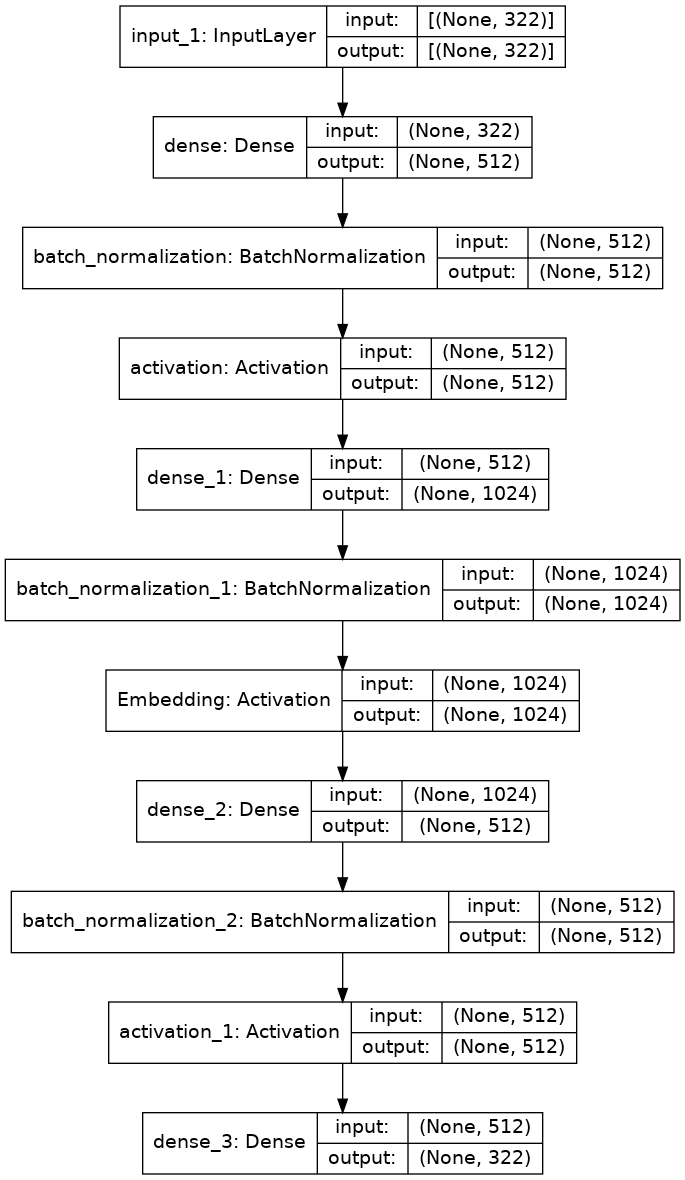

In [8]:
plot_model(
    model, to_file='./DAE_model.png', 
    show_shapes=True, show_layer_names=True
)

In [9]:
history = model.fit(
    Xtrain, 
    batch_size=mini_batch_size,
    epochs=250, 
    verbose=1, 
    workers=5,
    callbacks=[reduce_lr, early, chk_point], 
    validation_data=Xtest
)

Epoch 1/250
936/936 [==============================] - 40s 39ms/step - loss: 3.1800 - val_loss: 1.0741

Epoch 00001: val_loss improved from inf to 1.07405, saving model to ./DAE_model.h5
Epoch 2/250
936/936 [==============================] - 37s 39ms/step - loss: 0.9032 - val_loss: 0.6034

Epoch 00002: val_loss improved from 1.07405 to 0.60336, saving model to ./DAE_model.h5
Epoch 3/250
936/936 [==============================] - 37s 40ms/step - loss: 0.6619 - val_loss: 0.6303

Epoch 00003: val_loss did not improve from 0.60336
Epoch 4/250
936/936 [==============================] - 37s 39ms/step - loss: 0.5797 - val_loss: 0.5398

Epoch 00004: val_loss improved from 0.60336 to 0.53983, saving model to ./DAE_model.h5
Epoch 5/250
936/936 [==============================] - 37s 39ms/step - loss: 0.5443 - val_loss: 0.3705

Epoch 00005: val_loss improved from 0.53983 to 0.37054, saving model to ./DAE_model.h5
Epoch 6/250
936/936 [==============================] - 37s 40ms/step - loss: 0.5230 -

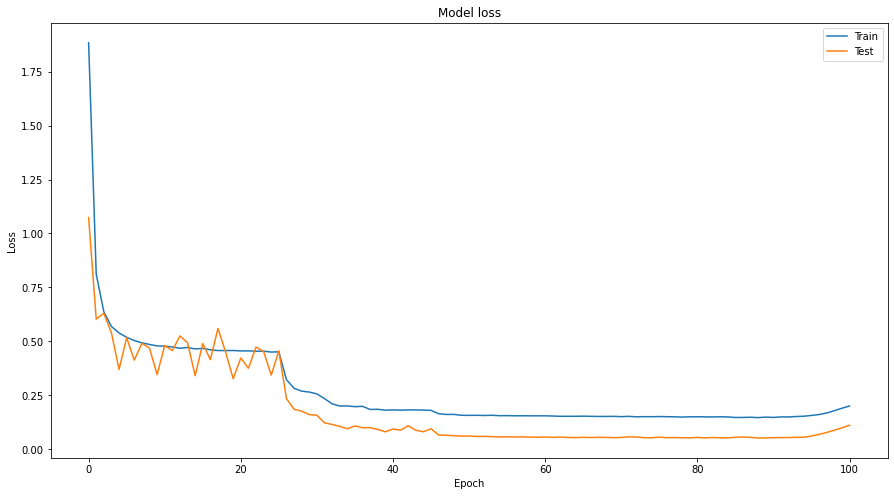

In [10]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Validate autoencoder output

In [11]:
model = load_model('./DAE_model.h5')
y_pred = model.predict(test_.values)
y_pred.shape

(29984, 322)

In [12]:
test_.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40
36597,1.358913,1.371657,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,0.879040,1.020888,0.621099,...,3.349694,0.151208,7.658840,-5.740939,19.630574,14.122170,-2.231444,-4.557736,3.654356,12.618775
56690,-5.199338,-5.199338,-5.199338,1.362078,-5.199338,-5.199338,-5.199338,0.576075,-5.199338,2.013671,...,11.805563,-4.394939,-2.889568,0.709136,-5.390746,-1.825647,-1.576954,-1.658750,1.378458,-3.270036
79178,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.055293,-5.199338,-5.199338,0.621099,...,-1.042671,-3.185109,-2.866854,0.730296,-2.606314,-1.879002,-2.069632,-1.922897,1.216621,-1.983278
99288,-5.199338,1.767903,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,1.275302,-5.199338,-5.199338,...,-0.360056,2.347034,-1.858536,1.745991,-0.587148,16.447393,3.465231,10.221017,9.697588,-2.041433
138868,-5.199338,-5.199338,-5.199338,-5.199338,1.918441,1.490335,-5.199338,-5.199338,3.121095,-5.199338,...,-1.212697,3.948887,6.843252,13.385917,-2.375557,-2.500393,11.558775,-8.061222,-1.772753,-1.897334


In [13]:
df = pd.DataFrame(y_pred, columns=test_.columns)
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40
0,1.349943,1.353031,-5.171198,-5.156451,-5.217255,-5.121624,-5.226887,1.078048,1.390081,0.796481,...,3.323773,0.063666,8.021014,-5.973735,19.747461,13.669813,-2.211438,-4.375714,3.647583,11.276480
1,-5.157366,-5.212851,-5.169585,1.615162,-5.170780,-5.184712,-5.192706,0.671314,-5.168364,2.034176,...,12.464893,-4.572575,-2.920991,0.775322,-5.529373,-1.938482,-1.551744,-1.635234,1.399446,-3.287365
2,-5.192298,-5.198506,-5.168838,-5.178806,-5.191944,-5.167902,1.325243,-5.220436,-5.174042,0.823042,...,-0.998536,-3.203846,-2.965375,0.834148,-2.651316,-1.929856,-2.006903,-1.905810,1.325249,-1.893853
3,-5.178994,1.638817,-5.168789,-5.170391,-5.162227,-5.135748,-5.177614,1.445746,-5.145848,-5.129115,...,-0.478890,2.520994,-1.846778,1.638529,-0.560970,16.053461,3.484183,10.004917,9.677268,-1.960209
4,-5.225818,-5.110907,-5.160585,-5.159140,2.012260,1.757068,-5.214296,-5.214769,2.072879,-5.149449,...,-1.196833,4.235273,6.883036,13.524269,-2.432008,-2.384165,11.820703,-8.114524,-1.924963,-1.838453


In [14]:
mse = (np.square(test_.values - df.values)).mean()
print("MSE: {}".format(mse))

MSE: 0.020037911507985395
